### Hypothesis for Soybean directional, using the oilseeds complex as a lead driver.
* We will test the relationship of the crush components of soybeans and its short term impact on directionality

### Building a Linear Regression model for Soybeans
* We will use Pytorch for the model
* The variables will be the crush skew and crush for the dependents
* We will perform a time series analysis using auto regression.


# Importing Libraries

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import yfinance as yf



In [163]:
# Data retrieval & Inspect

tickers = ['CL=F', 'RB=F']
start_date = '2024-01-01'
end_date = '2025-11-10'
freq = '1h'

# Download both Close and Volume
data = yf.download(tickers, start=start_date, end=end_date, interval=freq)[['Close', 'Volume']]

# Flatten MultiIndex columns
data.columns = [f"{field}_{ticker.replace('=F', '')}" for field, ticker in data.columns]

# Ensure datetime index
data.index = pd.to_datetime(data.index)

data.head()

#data.describe()
#data.isna().mean()
#data.value_counts()



C:\Users\Amin\AppData\Local\Temp\ipykernel_21044\505053934.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, interval=freq)[['Close', 'Volume']]
[*********************100%***********************]  2 of 2 completed

2 Failed downloads:
['CL=F', 'RB=F']: YFPricesMissingError('possibly delisted; no price data found  (15m 2024-01-01 -> 2025-11-10) (Yahoo error = "15m data not available for startTime=1704085200 and endTime=1762750800. The requested range must be within the last 60 days.")')


,Close_CL,Close_RB,Volume_CL,Volume_RB
Date,,,,


<Axes: xlabel='Datetime'>

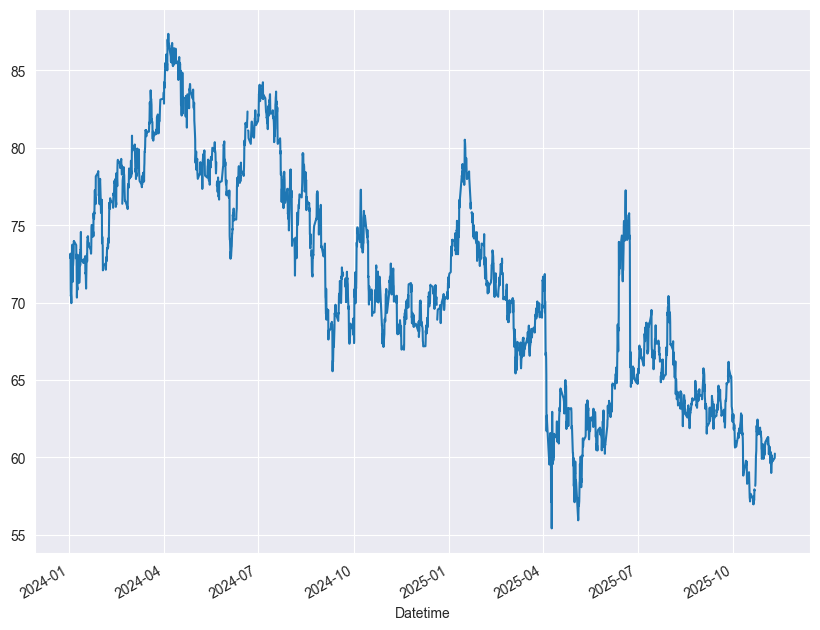

In [62]:
# visualize the dataframe
data['Close_CL'].plot(figsize=(10,8), grid=True)


### Feature engineering
* Create target and lagged feature for the analysis

In [144]:
# Create crush skew formula

prices = data.copy()
#prices['crush'] = (data['Close_ZS'] * 10) -(data['Close_ZM'] * 11) -(data['Close_ZL'] * 9)
#prices['crush_skew'] = (data['Close_ZS'] * 6) -(data['Close_ZM'] * 11) -(data['Close_ZL'] * 9)
#prices['crush'].plot(figsize=(10,8), grid=True)
#prices

In [146]:
target = 'cl_close_log_return'
max_lags = 4
forecast_horizon = 1

# Create log prices

prices = prices.sort_index()
prices['cl_close_log_return'] = np.log(prices['Close_CL']/prices['Close_CL'].shift(forecast_horizon))
prices['rb_close_log_return'] = np.log(prices['Close_RB']/prices['Close_RB'].shift(forecast_horizon))
#prices['crush_skew_close_log_return'] = np.log(prices['crush_skew']/prices['crush_skew'].shift(forecast_horizon))

#(prices[['Close_ZS','crush','crush_skew']] <= 0).any()

# Create lagged features.
prices[f'{target}_lag_1'] = prices[target].shift(forecast_horizon * 1)
prices[f'{target}_lag_2'] = prices[target].shift(forecast_horizon * 2)
prices[f'{target}_lag_3'] = prices[target].shift(forecast_horizon * 3)
prices[f'{target}_lag_4'] = prices[target].shift(forecast_horizon * 4)

prices['rb_close_lag_1'] = prices['rb_close_log_return'].shift(forecast_horizon * 1)
prices['rb_close_lag_2'] = prices['rb_close_log_return'].shift(forecast_horizon * 2)
prices['rb_close_lag_3'] = prices['rb_close_log_return'].shift(forecast_horizon * 3)
prices['rb_close_lag_4'] = prices['rb_close_log_return'].shift(forecast_horizon * 4)

#prices['crushskew_close_lag_1'] = prices['crush_skew_close_log_return'].shift(forecast_horizon * 1)
#prices['crushskew_close_lag_2'] = prices['crush_skew_close_log_return'].shift(forecast_horizon * 2)
#prices['crushskew_close_lag_3'] = prices['crush_skew_close_log_return'].shift(forecast_horizon * 3)
#prices['crushskew_close_lag_4'] = prices['crush_skew_close_log_return'].shift(forecast_horizon * 4)

prices.dropna(inplace=True)

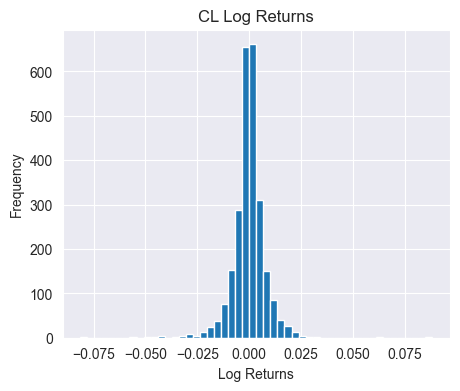

In [65]:
# Plot distribution of close log returns for Soybeans
prices['cl_close_log_return'].hist(bins=50, figsize=(5,4), grid=True)
plt.title('CL Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.show()

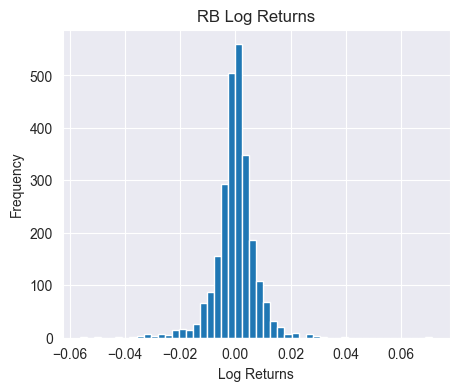

In [66]:
prices['rb_close_log_return'].hist(bins=50, figsize=(5,4), grid=True)
plt.title('RB Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.show()

In [67]:
prices['crush_skew_close_log_return'].hist(bins=50, figsize=(5,4), grid=True)
plt.title('CrushSkew Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.show()

KeyError: 'crush_skew_close_log_return'

### Building the Model

In [148]:
# we will use a linear model from Pytorch.

class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)

### Splitting the model by time to ensure no data leakage

In [149]:
#'crushskew_close_lag_1','crushskew_close_lag_3','crush_close_lag_1','crush_close_lag_2'
features = ['rb_close_lag_1', 'rb_close_lag_2','rb_close_lag_3','rb_close_lag_4']
target = ['cl_close_log_return']
test_size = 0.25

In [150]:
len(prices)

9201

In [151]:
len(prices) * test_size

2300.25

In [152]:
# to split the data by time, we will split it by the index.
# this will give us the train size below

split_idx = int(len(prices) * (1-test_size))
split_idx

6900

In [153]:
# split time series into 2 parts

prices_train, prices_test = prices[:split_idx], prices[split_idx:]

prices_train.head()

,Close_CL,Close_RB,Volume_CL,Volume_RB,cl_close_log_return,rb_close_log_return,cl_close_log_return_lag_1,cl_close_log_return_lag_2,cl_close_log_return_lag_3,cl_close_log_return_lag_4,rb_close_lag_1,rb_close_lag_2,rb_close_lag_3,rb_close_lag_4
Datetime,,,,,,,,,,,,,,
2024-01-02 15:00:00+00:00,71.540001,2.1137,31885.0,3177.0,-0.001536,0.002605,-0.025628,0.004773,-0.001093,-0.003272,-0.027971,0.006014,-0.000046,-0.003150
2024-01-02 16:00:00+00:00,70.860001,2.1017,41336.0,5343.0,-0.009551,-0.005693,-0.001536,-0.025628,0.004773,-0.001093,0.002605,-0.027971,0.006014,-0.000046
2024-01-02 17:00:00+00:00,71.199997,2.1202,21648.0,4281.0,0.004787,0.008764,-0.009551,-0.001536,-0.025628,0.004773,-0.005693,0.002605,-0.027971,0.006014
2024-01-02 18:00:00+00:00,70.300003,2.0857,21450.0,6453.0,-0.012721,-0.016406,0.004787,-0.009551,-0.001536,-0.025628,0.008764,-0.005693,0.002605,-0.027971
2024-01-02 19:00:00+00:00,70.489998,2.1008,31931.0,8644.0,0.002699,0.007214,-0.012721,0.004787,-0.009551,-0.001536,-0.016406,0.008764,-0.005693,0.002605


In [154]:
prices_test.head()

,Close_CL,Close_RB,Volume_CL,Volume_RB,cl_close_log_return,rb_close_log_return,cl_close_log_return_lag_1,cl_close_log_return_lag_2,cl_close_log_return_lag_3,cl_close_log_return_lag_4,rb_close_lag_1,rb_close_lag_2,rb_close_lag_3,rb_close_lag_4
Datetime,,,,,,,,,,,,,,
2025-06-02 10:00:00+00:00,63.389999,2.0776,14925.0,1957.0,0.004744,0.003230,0.003493,0.006703,-0.000960,0.000320,0.004064,0.004860,0.002097,0.001221
2025-06-02 11:00:00+00:00,63.340000,2.0751,12487.0,2379.0,-0.000789,-0.001204,0.004744,0.003493,0.006703,-0.000960,0.003230,0.004064,0.004860,0.002097
2025-06-02 12:00:00+00:00,63.570000,2.0849,30794.0,6805.0,0.003625,0.004712,-0.000789,0.004744,0.003493,0.006703,-0.001204,0.003230,0.004064,0.004860
2025-06-02 13:00:00+00:00,62.660000,2.0649,58727.0,10403.0,-0.014418,-0.009639,0.003625,-0.000789,0.004744,0.003493,0.004712,-0.001204,0.003230,0.004064
2025-06-02 14:00:00+00:00,62.820000,2.0639,37793.0,6007.0,0.002550,-0.000484,-0.014418,0.003625,-0.000789,0.004744,-0.009639,0.004712,-0.001204,0.003230


In [155]:
# We need to convert the split into sensors. Splitting our input and output into separate variables.

x_train = torch.tensor(prices_train[features].to_numpy(), dtype=torch.float32)
x_test = torch.tensor(prices_test[features].to_numpy(), dtype=torch.float32)
y_train = torch.tensor(prices_train[target].to_numpy(), dtype=torch.float32)
y_test = torch.tensor(prices_test[target].to_numpy(), dtype=torch.float32)

In [156]:
x_train.shape

torch.Size([6900, 4])

In [157]:
y_test.shape

torch.Size([2301, 1])

In [158]:
y_train.shape

torch.Size([6900, 1])

In [159]:
# We need to fit the scaler

from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(prices_train[features].values)
X_train_np = x_scaler.transform(prices_train[features].values)
X_test_np  = x_scaler.transform(prices_test[features].values)

# Replace old torch tensor
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32)

### Training the model


In [160]:
# specify hyperparameters which can be tweaked to improve model performance

no_epochs = 1000 * 5
lr = 0.0005

# Create Model
model = LinearModel(len(features))

#Loss Function L1Loss/MSE / L1Loss has been the strongest performer through testing
criterion = nn.L1Loss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

print('\nTraining...')
for epoch in range(no_epochs):
    # forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)

    # Backward pass
    optimizer.zero_grad() # 1. clear old gradients
    loss.backward()       # 2. compute new gradients
    optimizer.step()      # 3. update weights

    # check for improvements by logging
    train_loss = loss.item()

    # logging
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss:.6f}')

    print('\nLearned parameters:')

    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}:\n {param.data.numpy()}')

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_hat = model(X_test)
        test_loss = criterion(y_hat, y_test)
        print(f'\nTest loss: {test_loss.item():.6f}, Train loss: {train_loss:.6f}')



Training...

Learned parameters:
linear.weight:
 [[-0.49389204 -0.03095927 -0.30717835 -0.3728355 ]]
linear.bias:
 [0.20861366]

Test loss: 0.547725, Train loss: 0.457283

Learned parameters:
linear.weight:
 [[-0.49339205 -0.03045927 -0.30667835 -0.3723355 ]]
linear.bias:
 [0.20811367]

Test loss: 0.547011, Train loss: 0.456614

Learned parameters:
linear.weight:
 [[-0.49289203 -0.02995966 -0.30617836 -0.3718355 ]]
linear.bias:
 [0.20761372]

Test loss: 0.546297, Train loss: 0.455946

Learned parameters:
linear.weight:
 [[-0.49239197 -0.02946038 -0.3056784  -0.37133545]]
linear.bias:
 [0.20711385]

Test loss: 0.545586, Train loss: 0.455278

Learned parameters:
linear.weight:
 [[-0.49189192 -0.02896138 -0.30517843 -0.3708354 ]]
linear.bias:
 [0.20661403]

Test loss: 0.544878, Train loss: 0.454610

Learned parameters:
linear.weight:
 [[-0.49139187 -0.02846314 -0.3046784  -0.37033528]]
linear.bias:
 [0.20611435]

Test loss: 0.544171, Train loss: 0.453943

Learned parameters:
linear.weigh

# Evaluating trading performance
* Create trade results from test data

In [161]:
# Create base DataFrame
trade_results = pd.DataFrame({
    'y_hat': np.squeeze(y_hat),
    'y': np.squeeze(y_test),
})

# Add calculated columns
trade_results['is_won'] = np.sign(trade_results['y_hat']) == np.sign(trade_results['y'])
trade_results['signal'] = np.sign(trade_results['y_hat'])
trade_results['trade_log_return'] = trade_results['signal'] * trade_results['y']
trade_results['equity_curve'] = trade_results['trade_log_return'].cumsum()

trade_results.head()


,y_hat,y,is_won,signal,trade_log_return,equity_curve
0,0.000052,0.004744,True,1.0,0.004744,0.004744
1,0.000008,-0.000789,False,1.0,-0.000789,0.003955
2,-0.000015,0.003625,False,-1.0,-0.003625,0.000330
3,0.000038,-0.014418,False,1.0,-0.014418,-0.014088
4,0.000039,0.002550,True,1.0,0.002550,-0.011538


### Visualize the equity curve in log space

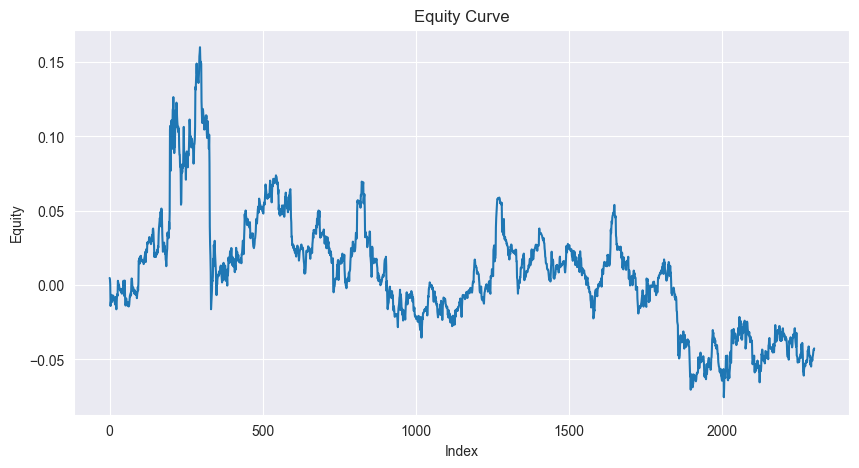

In [162]:
y = trade_results['equity_curve']
plt.figure(figsize=(10,5))
plt.plot(y)
plt.title('Equity Curve')
plt.xlabel('Index')
plt.ylabel('Equity')
plt.show()

In [27]:
# Calculate drawdown from the cumulative equity curve
trade_results['drawdown_log'] = trade_results['equity_curve'] - trade_results['equity_curve'].cummax()

trade_results.head()


,y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
0,0.003205,-0.021590,False,1.0,-0.021590,-0.021590,0.000000
1,0.000831,-0.017640,False,1.0,-0.017640,-0.039231,-0.017640
2,0.001091,0.015212,True,1.0,0.015212,-0.024018,-0.002428
3,0.002921,-0.019508,False,1.0,-0.019508,-0.043527,-0.021936
4,0.001203,-0.030197,False,1.0,-0.030197,-0.073724,-0.052133


### Trading performance breakdown

In [28]:
# Max DD log

max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

np.float32(-0.19241735)

In [29]:
# Putting into simple returns
drawdown_pct = np.exp(max_drawdown_log)-1
drawdown_pct

np.float32(-0.17503744)

In [30]:
equity_peak = 1000
equity_peak * drawdown_pct

np.float32(-175.03745)

In [31]:
# Win rate
win_rate = trade_results['is_won'].mean()
win_rate

np.float64(0.5063694267515924)

In [32]:
# Expected Value
avg_win = trade_results.loc[trade_results['is_won'], 'trade_log_return'].mean()
avg_loss = trade_results.loc[~trade_results['is_won'], 'trade_log_return'].mean()

win_rate = trade_results['is_won'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss

print(f"Expected Value per trade: {ev:.6f}")


Expected Value per trade: 0.000315


In [33]:
# total log return
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

np.float32(0.098795295)

In [34]:
compound_return = np.exp(total_log_return)
compound_return

np.float32(1.1038404)

In [35]:
1000*compound_return

np.float32(1103.8403)

In [36]:
# Equity trough

equity_trough = trade_results['equity_curve'].min()
equity_trough

np.float32(-0.16423713)

In [37]:
# Equity peak

equity_peak = trade_results['equity_curve'].max()
equity_peak

np.float32(0.20710346)

In [38]:
# std
std = trade_results['trade_log_return'].std()
std

np.float32(0.020708885)

In [39]:
# Sharpe
annualized_rate = np.sqrt(252)

sharpe = ev / std * annualized_rate
sharpe

np.float64(0.24118496304228002)

### Strategy Development - Trade Sizing